In [21]:
# Advanced lane lines project: Udacity

In [22]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import glob
from moviepy.editor import VideoFileClip

print('All required headers are imported')

All required headers are imported


In [23]:
# Function to undistort images

In [24]:
def undistort(image, mtx, dist):
    #print(image.shape)
    image = cv2.undistort(image, mtx, dist, None, mtx)
   # print("image rectified ...")
    return image

In [25]:
# Function to draw chessboard corners

In [26]:
def drawchessboardcorner(img, corners_horizontal, corners_vertical, ret):
    print("chessboard corners drawn ...")
    return cv2.drawChessboardCorners(img, (8,6), corners, ret)

In [27]:
# Function to find calibration matrx

In [28]:
def findcalibrationmatrix(image_count, corners_horizontal, corners_vertical):  
    
    data_dir = os.path.join(os.getcwd(), 'camera_cal/')
    
    #images = glob.glob('../camera_cal/calibration*.jpg')
    
    objpoints=[]
    imgpoints=[]
    
    objp= np.zeros((corners_vertical*corners_horizontal,3), np.float32)
    objp[:,:2]=np.mgrid[0:corners_horizontal, 0:corners_vertical].T.reshape(-1, 2)    
    
    k=0
        
    #for img_name in images:  
    while k < image_count:
        k=k+1
        img_name = data_dir+"calibration"+str(k)+".jpg"
        #print(img_name)
        img = cv2.imread(img_name)         
        img_gray =cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                
        ret, corners = cv2.findChessboardCorners(img_gray, (corners_horizontal, corners_vertical), None)
        #print(ret)
        if ret==True:
           # print("True")
            imgpoints.append(corners)
            objpoints.append(objp)
            draw_img = img_gray
            draw_img = cv2.drawChessboardCorners(draw_img, (8,6), corners, ret)
            # To display a couple of images, Only for visualization
            if(k>10 and k<12):
                f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12, 18))
                ax1.imshow(img)
                ax1.set_title('Image', fontsize=15)
                ax2.imshow(draw_img)
                ax2.set_title('corners', fontsize=15)
                plt.show()
                img_BGR = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
                #corners_BGR = cv2.cvtColor(draw_img, cv2.COLOR_RGB2BGR)
                cv2.imwrite( "output_images/checkerboard_img.jpg",  img_BGR);
                cv2.imwrite( "output_images/checkerboard_corners.jpg",  draw_img);
    return objpoints, imgpoints

In [29]:
# Pipeline to  find calibration matrix

In [30]:
def calibrate(objpoints, imgpoints):
    data_dir = os.path.join(os.getcwd(), 'camera_cal/')
    image = data_dir+"calibration1.jpg"
   # print(image)

    img = cv2.imread(image) 
    img_size = (img.shape[1], img.shape[0])
    #print(img_size)
    #print(cv2.calibrateCamera(objpoints, imgpoints,(img.shape[1], img.shape[0]), None, None))
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (img.shape[1], img.shape[0]), None, None)
    return ret, mtx, dist, rvecs, tvecs

In [31]:
# function to do prespective transform 

In [32]:
def transform_image(undist,src,dst):
    img_size = (undist.shape[1], undist.shape[0])
    image_tr = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, image_tr, img_size )
    return warped

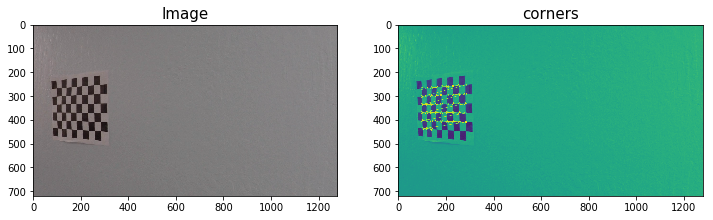

calibration matrix is sucessfully found


In [33]:
objpoints, imgpoints = findcalibrationmatrix(20, 9, 6)

print('calibration matrix is sucessfully found')

dist: 
 [[ -2.41017956e-01  -5.30721171e-02  -1.15810354e-03  -1.28318858e-04
    2.67125300e-02]]
calibration parameters are sucessfully found


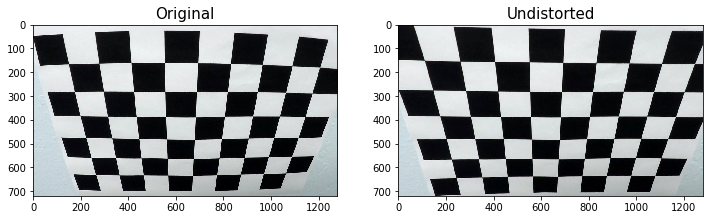

In [34]:
ret, mtx, dist, rvecs, tvecs=calibrate(objpoints, imgpoints)
print("dist: \n", dist)
print('calibration parameters are sucessfully found')

checker_dist = cv2.imread("./camera_cal/calibration2.jpg")
checker_undist = undistort(checker_dist, mtx, dist)

f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12, 18))
ax1.imshow(checker_dist)
ax1.set_title('Original', fontsize=15)
ax2.imshow(checker_undist)
ax2.set_title('Undistorted', fontsize=15)
plt.show()
checker_dist_BGR = cv2.cvtColor(checker_dist, cv2.COLOR_RGB2BGR)
checker_undist_BGR = cv2.cvtColor(checker_undist, cv2.COLOR_RGB2BGR)
cv2.imwrite( "output_images/checkerboard_distorted.jpg",  checker_dist_BGR);
cv2.imwrite( "output_images/checkerboard_undistorted.jpg",  checker_undist_BGR);

#ax2.show()

In [35]:
def preprocess_image(image, verbose):
    #h,w = image.shape[:2]
    #convert image HSV Colorspace
    ###############
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    yellow_lower = np.array([20,60,60])
    yellow_upper = np.array([38,174, 250])
    yellow_mask = cv2.inRange(hsv, yellow_lower, yellow_upper)
    
    white_lower = np.array([202,202,202])
    white_upper = np.array([255,255,255])
    white_mask = cv2.inRange(image, white_lower, white_upper)
    
    combined_binary = np.zeros_like(yellow_mask)
    combined_binary[(yellow_mask >= 1) | (white_mask >= 1)] = 1
    
    if verbose:        
        f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12, 18))
        ax1.imshow(image)
        ax1.set_title('Original image', fontsize=15)
        ax2.imshow(combined_binary)
        ax2.set_title('combined_binary', fontsize=15)
        plt.show()
        
        image_BGR = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)        
        cv2.imwrite( "output_images/undistorted_image.jpg", image_BGR);
        cv2.imwrite( "output_images/combined_binary.jpg", combined_binary);
    
    return combined_binary


In [36]:
def find_lanes(original_image, preprocessed_image, rectified_image, src, dst, verbose):
    
    #print("sliding window ...")
    
    # Assuming that the upper half of the image have no lane, histogram is taken only on the bottom half  
    histogram = np.sum(preprocessed_image[preprocessed_image.shape[0]//2:,:], axis=0)    
  
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((preprocessed_image, preprocessed_image, preprocessed_image))*255
    
    # Find the peak of the left and right halves of the histogram
    peak = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:peak])
    rightx_base = np.argmax(histogram[peak:]) + peak

    
    # Set how many no of windows to be processed and its height
    nwindows = 9
    window_height = np.int(preprocessed_image.shape[0]/nwindows)

    # All nonzero pixels in the image
    nonzero = preprocessed_image.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])
        
    # Find the current position 
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the Width of the window and minimum amount of pixel to center a window
    width = 100
    minpix = 50
        
    left_lane_index = []
    right_lane_index = []
    rectangle_data = []
    # loop through the windows one by one and find best points
    for window in range(nwindows):
        win_y_low = preprocessed_image.shape[0] - (window+1)*window_height
        win_y_high = preprocessed_image.shape[0] - window*window_height
        
        win_xleft_low = leftx_current - width
        win_xleft_high = leftx_current + width
        win_xright_low = rightx_current - width
        win_xright_high = rightx_current + width
                       
        # Identify the nonzero pixels in x and y within the window
        good_left_index = ((nonzero_y >= win_y_low) & (nonzero_y < win_y_high) & (nonzero_x >= win_xleft_low) & (nonzero_x < win_xleft_high)).nonzero()[0]
        good_right_index = ((nonzero_y >= win_y_low) & (nonzero_y < win_y_high) & (nonzero_x >= win_xright_low) & (nonzero_x < win_xright_high)).nonzero()[0]
        
        rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        
        # Append these indices
        left_lane_index.append(good_left_index)
        right_lane_index.append(good_right_index)
        
        # recenter next window on the mean position
        if len(good_left_index) > minpix:
            leftx_current = np.int(np.mean(nonzero_x[good_left_index]))
        if len(good_right_index) > minpix:        
            rightx_current = np.int(np.mean(nonzero_x[good_right_index]))
            
        # Draw the windows 
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 


    # Concatenate the arrays of indices
    left_lane_index = np.concatenate(left_lane_index)
    right_lane_index = np.concatenate(right_lane_index)

    # Extract left and right line pixel positions
    leftx = nonzero_x[left_lane_index]
    lefty = nonzero_y[left_lane_index] 
    rightx = nonzero_x[right_lane_index]
    righty = nonzero_y[right_lane_index] 

    # Fit a second order polynomial to each
    if len(leftx) != 0 and len(rightx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        ploty = np.linspace(0, rectified_image.shape[0]-1, rectified_image.shape[0] )
        
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
      
        out_img[nonzero_y[left_lane_index], nonzero_x[left_lane_index]] = [255, 190, 0]
        out_img[nonzero_y[right_lane_index], nonzero_x[right_lane_index]] = [0, 190, 255]

        if verbose:
            plt.imshow(out_img)
            plt.title('Lanes')
            plt.plot(left_fitx, ploty, color='yellow')
            plt.plot(right_fitx, ploty, color='yellow')
            plt.xlim(0, 1280)
            plt.ylim(720, 0)    
            plt.show()
        
        
        # pixels in meters
        y_dist = 30/720 
        x_dist = 3.7/700
               
        y_eval = np.max(ploty)  
        
        curve_leftx  = np.polyfit(ploty*y_dist, left_fitx*x_dist, 2)  
        curve_rightx = np.polyfit(ploty*y_dist, right_fitx*x_dist, 2)  
                    
        y_eval = np.max(ploty)
    
        left_curverad = ((1 + (2*curve_leftx[0]*y_eval*y_dist + curve_leftx[1])**2)**1.5) / np.absolute(2*curve_leftx[0])
        right_curverad = ((1 + (2*curve_rightx[0]*y_eval*y_dist + curve_rightx[1])**2)**1.5) / np.absolute(2*curve_rightx[0])
     
#        vehicle_position = preprocessed_image.shape[1]/2.0
#        lane_center= (left_curverad+right_curverad)/2
#        center_dist = (vehicle_position - lane_center) * x_dist

       # Create an image to draw the lines
        warp_zero = np.zeros_like(preprocessed_image).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
                
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
        cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,100,255), thickness=15)
        cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(100,255,255), thickness=15)

        
        Minv = cv2.getPerspectiveTransform(dst, src)
        newwarp = cv2.warpPerspective(color_warp, Minv, (preprocessed_image.shape[1], preprocessed_image.shape[0]))

        # Draw lanes by masking
        result = cv2.addWeighted(rectified_image, 1, newwarp, 0.5, 0)   
        
        # Assuming that the camera is mounted at the center of the car
        car_mid=640
        
        left_mean = left_fitx[-1]
        right_mean = right_fitx[-1]
        position = car_mid -abs((left_mean+right_mean)/2)
        position = position*x_dist
               
        font = cv2.FONT_HERSHEY_DUPLEX
        dist_l = "left_curverad: "+str(left_curverad)+ " m"
        dist_r = "right_curverad: "+str(right_curverad)+ " m"
        
        if position <0:
            position= abs(position)
            distance_to_center="Distance_to_center: "+str(position) +" m to left"
        else:
            position= abs(position)
            distance_to_center="Distance_to_center: "+str(position) +" m to right"
        #distance_to_center="Distance_to_center: "+str(position)
        cv2.putText(result,str(dist_l) , (181,71), font, 1, (0,0,0), 1, cv2.LINE_AA)
        cv2.putText(result,str(dist_r) , (181,101), font, 1, (0,0,0), 1, cv2.LINE_AA)
        cv2.putText(result,str(distance_to_center) , (181,141), font, 1, (0,0,0), 1, cv2.LINE_AA)
                
        
        if verbose:
            plt.imshow(result)
            plt.title("result")
            plt.show()
        return result
    
    else:
        return original_image

In [37]:
def pipeline(dist):
    verbose = True
    data_dir = os.path.join(os.getcwd(), 'test_images/')
    image_location = data_dir+"test3.jpg"
    print(image_location)
    
    # 1: Read the image
    test_img = mpimg.imread(image_location)
    rgb_image = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
    # 2: Rectify the image
    rectified_image = undistort(test_img, mtx, dist)
    
    if verbose:
        f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12, 18))
        ax1.imshow(test_img)
        ax1.set_title('Original', fontsize=15)
        ax2.imshow(rectified_image)
        ax2.set_title('Rectified', fontsize=15)
        test_img_BGR = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
        cv2.imwrite( "output_images/distorted_image.jpg", test_img_BGR);
    
    # 3: Preprocess the image
    preprocessed_image = preprocess_image(rectified_image, verbose)
    
    if verbose:    
        f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12, 18))
        ax1.imshow(rectified_image)
        ax1.set_title('rectified_image', fontsize=15)
        ax2.imshow(preprocessed_image)
        ax2.set_title('preprocessed_image', fontsize=15)    
        plt.show()
    
    # 4: transform the image 
    height, width =preprocessed_image.shape[:2]


    pts = np.array([[900,682],[258,682],[600,445],[680,445]], dtype=np.int32 )
        
    src = np.float32([[545, 460],
                    [735, 460],
                    [1280, 700],
                    [0, 700]])

    dst = np.float32([[0, 0],
                     [1280, 0],
                     [1280, 720],
                     [0, 720]])

    img = test_img.copy()

    pts = np.array([[0,700],[1280,700],[545,460],[735,460]], dtype=np.int32 )
    #pts = pts.reshape((-1,1,2))
    cv2.fillPoly(img,[pts],(0,255,0))

   # if verbose:
   #     plt.imshow(img)
   #     plt.title('rect_img')
   #     plt.show()

    warped_image = transform_image(preprocessed_image, src, dst)*255
    
    if verbose:    
        f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12, 18))
        ax1.imshow(rectified_image)
        ax1.set_title('Original_Image', fontsize=15)
        ax2.imshow(warped_image)
        ax2.set_title('warped_image', fontsize=15)
        plt.show()
        cv2.imwrite( "output_images/warped_image.jpg", warped_image);

    ############################TEST##################################
        
    result = find_lanes(test_img, warped_image, rectified_image, src, dst, verbose)
    
    if verbose:
        result_BGR = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
        cv2.imwrite( "output_images/result.jpg", result_BGR);
 
    return result
    ##################################################################  

In [38]:
def pipeline_video(test_img):
    verbose =False
    # 2: Rectify the image
    rectified_image = undistort(test_img, mtx, dist)
    
    if verbose:
        f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12, 18))
        ax1.imshow(test_img)
        ax1.set_title('Original', fontsize=15)
        ax2.imshow(rectified_image)
        ax2.set_title('Rectified', fontsize=15)
        test_img_BGR = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
        cv2.imwrite( "output_images/distorted_image.jpg", test_img_BGR);

    
    # 3: Preprocess the image
    preprocessed_image = preprocess_image(rectified_image, verbose)
    
    if verbose:
        f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12, 18))
        ax1.imshow(rectified_image)
        ax1.set_title('rectified_image', fontsize=15)
        ax2.imshow(preprocessed_image)
        ax2.set_title('preprocessed_image', fontsize=15)    
        plt.show()
    
    # 4: transform the image 
    height, width =preprocessed_image.shape[:2]
    src = np.float32([[545, 460],
                    [735, 460],
                    [1280, 700],
                    [0, 700]])

    dst = np.float32([[0, 0],
                     [1280, 0],
                     [1280, 720],
                     [0, 720]])

    img = test_img.copy()

    pts = np.array([[0,700],[1280,700],[545,460],[735,460]], dtype=np.int32 )
    #pts = pts.reshape((-1,1,2))
    cv2.fillPoly(img,[pts],(0,255,0))
    
    #if verbose:
    #    plt.imshow(img)
    #    plt.title('rect_img')
    #    plt.show()

    warped_image = transform_image(preprocessed_image, src, dst)*255
        
    if verbose:
        f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12, 18))
        ax1.imshow(rectified_image)
        ax1.set_title('Original_Image', fontsize=15)
        ax2.imshow(warped_image)
        ax2.set_title('warped_image', fontsize=15)
        plt.show()
        cv2.imwrite( "output_images/warped_image.jpg", warped_image );

    ############################Finding lanes##################################
    
    result = find_lanes(test_img, warped_image, rectified_image, src, dst, verbose)
    
    if verbose:
        result_BGR = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
        cv2.imwrite( "output_images/result.jpg", result_BGR);
        
    return result
 
    ################################################################## 

In [39]:
'''''''''''''''
def process_video():
    #video_output1 = 'project_video_output.mp4'
    
    output = 'project_video_output.mp4'
    cap = cv2.VideoCapture("project_video.mp4") 
    success = True
    while success:
        success, frame = cap.read()
#print(frame.shape)
        plt.imshow(frame)
        plt.show()
        pipeline_video(frame)
#        print('------')
'''''''''''''''

'\ndef process_video():\n    #video_output1 = \'project_video_output.mp4\'\n    \n    output = \'project_video_output.mp4\'\n    cap = cv2.VideoCapture("project_video.mp4") \n    success = True\n    while success:\n        success, frame = cap.read()\n#print(frame.shape)\n        plt.imshow(frame)\n        plt.show()\n        pipeline_video(frame)\n#        print(\'------\')\n'

/src/test_images/test3.jpg


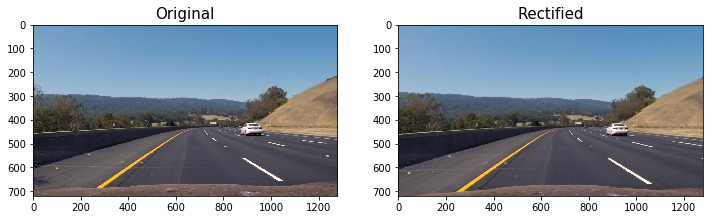

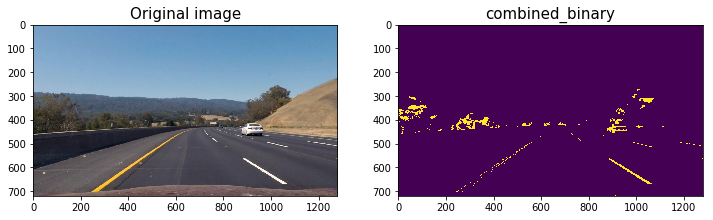

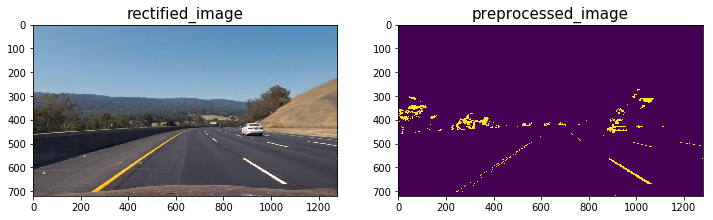

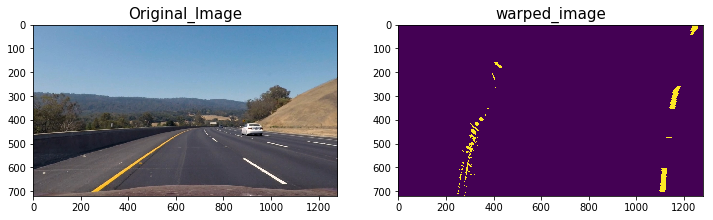

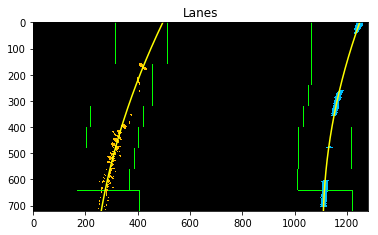

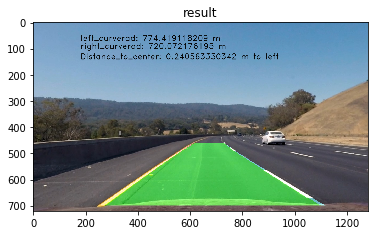

In [40]:
# Process test image
result = pipeline(dist)

In [41]:
#process_video()
output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(pipeline_video)
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [02:00<00:00,  8.38it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 9min 41s, sys: 2.18 s, total: 9min 44s
Wall time: 2min 1s


In [42]:
output = 'harder_challenge_video_output.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
clip = clip1.fl_image(pipeline_video)
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


100%|█████████▉| 1199/1200 [02:28<00:00,  8.92it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

CPU times: user 10min 35s, sys: 3.01 s, total: 10min 38s
Wall time: 2min 29s


In [43]:
print("Succesfully completed ...")
print("»»»»»»»»»»«««««««««««««««")

Succesfully completed ...
»»»»»»»»»»«««««««««««««««
